In [137]:
# 1. Imports & Global Config

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import hdbscan
from matplotlib.ticker import MultipleLocator

# Reduce thread oversubscription
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")


'1'

In [138]:
# 2. Paths & Parameters

TM_NPY = Path("/home/ktkim/AllerScope_raw/data/manifold/tm_score_matrix.npy")
DIST_NPY = Path("/home/ktkim/AllerScope_raw/data/manifold/tm_distance_matrix.npy")
PDB_DIR = Path("/home/ktkim/AllerScope_raw/data/fungal_allergen/pdb")
OUT_DIR = Path("/home/ktkim/AllerScope_raw/analysis")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MIN_CLUSTER_SIZE = 5

TSNE_PERPLEXITY = 20
TSNE_RANDOM_STATE = 42
TSNE_INIT = "random"
TSNE_LEARNING_RATE = "auto"

FIGSIZE = (10, 10)
GRID_STEP = 5

In [139]:
# 3. Color Palette
# Okabe & Ito palette
OKABE_ITO = {
    "orange": "#E69F00",
    "sky_blue": "#56B4E9",
    "teal_green": "#009E73",
    "yellow": "#F0E442",
    "blue": "#0072B2",
    "vermilion": "#D55E00",
    "pink": "#CC79A7",
    "black": "#000000",
    "white": "#FFFFFF"
}

CLUSTER_COLOR_ORDER = [
    OKABE_ITO["orange"],
    OKABE_ITO["teal_green"],
    OKABE_ITO["blue"],
    OKABE_ITO["pink"],
    OKABE_ITO["sky_blue"],
    OKABE_ITO["yellow"],
    OKABE_ITO["vermilion"],
    OKABE_ITO["white"],
]

NOISE_COLOR = OKABE_ITO["white"]


In [140]:
# 4. Load Matrices

tm = np.load(TM_NPY)
dist = np.load(DIST_NPY)

assert tm.shape[0] == tm.shape[1]
assert dist.shape == tm.shape

n = dist.shape[0]
print(f"Loaded matrices: n={n}")
print(f"TM-score min/max: {tm.min():.4f} / {tm.max():.4f}")
print(f"Distance min/max: {dist.min():.4f} / {dist.max():.4f}")


Loaded matrices: n=150
TM-score min/max: 0.0852 / 1.0000
Distance min/max: 0.0000 / 0.9148


In [141]:
# 5. Load Protein IDs

pdb_files = sorted(PDB_DIR.glob("*.pdb"))
ids = [p.stem for p in pdb_files]

if len(ids) != n:
    raise RuntimeError(
        f"ID count mismatch: PDB={len(ids)} vs matrix={n}"
    )

ids[:5], len(ids)




(['A0A0F6N3V8', 'A0A0U1Y1N5', 'A0A3G3LP85', 'A2I7W3', 'A4FSH5'], 150)

In [142]:
# 6. Sanity Check
np.fill_diagonal(dist, 0.0)
dist = 0.5 * (dist + dist.T)

print("Diagonal min/max:", np.min(np.diag(dist)), np.max(np.diag(dist)))
print("Max asymmetry:", np.max(np.abs(dist - dist.T)))


Diagonal min/max: 0.0 0.0
Max asymmetry: 0.0


In [143]:
# 7. HDBSCAN Clustering

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    metric="precomputed",
)

labels = clusterer.fit_predict(dist)

unique_labels, counts = np.unique(labels, return_counts=True)
label2count = dict(zip(unique_labels, counts))

n_clusters = len([c for c in unique_labels if c != -1])
n_noise = label2count.get(-1, 0)

print(f"HDBSCAN clusters={n_clusters}, noise={n_noise}")


HDBSCAN clusters=7, noise=72


In [150]:
# 8. Clustering Ordering & Naming

# Sort clusters by size (descending)
cluster_ids_sorted = sorted(
    [c for c in unique_labels if c != -1],
    key=lambda c: label2count[c],
    reverse=True,
)

def cluster_name(k):
    return f"Cluster {chr(ord('A') + k)}"

cid2name = {cid: cluster_name(i) for i, cid in enumerate(cluster_ids_sorted)}
cid2color = {
    cid: CLUSTER_COLOR_ORDER[i % len(CLUSTER_COLOR_ORDER)]
    for i, cid in enumerate(cluster_ids_sorted)
}

for cid in cluster_ids_sorted:
    print(f"{cid2name[cid]} (HDBSCAN id={cid}): n={label2count[cid]}")


Cluster A (HDBSCAN id=4): n=24
Cluster B (HDBSCAN id=1): n=12
Cluster C (HDBSCAN id=3): n=12
Cluster D (HDBSCAN id=0): n=9
Cluster E (HDBSCAN id=2): n=9
Cluster F (HDBSCAN id=5): n=7
Cluster G (HDBSCAN id=6): n=5


In [145]:
# 9. t-SNE
tsne = TSNE(
    n_components=2,
    metric="precomputed",
    perplexity=TSNE_PERPLEXITY,
    random_state=TSNE_RANDOM_STATE,
    init=TSNE_INIT,
    learning_rate=TSNE_LEARNING_RATE,
)

coords = tsne.fit_transform(dist)
coords.shape


(150, 2)

In [146]:
# 10. Build Visualization DataFrame
df_viz = pd.DataFrame(
    {
        "id": ids,
        "x": coords[:, 0],
        "y": coords[:, 1],
        "hdbscan_id": labels,
        "cluster": [cid2name.get(c, "Noise") for c in labels],
    }
)

df_viz.head()


,id,x,y,hdbscan_id,cluster
0,A0A0F6N3V8,-17.408978,7.444448,4,A
1,A0A0U1Y1N5,-16.745924,5.587989,4,A
2,A0A3G3LP85,7.988931,-11.666077,0,D
3,A2I7W3,-5.987523,9.593703,-1,Noise
4,A4FSH5,12.322165,-9.716471,-1,Noise


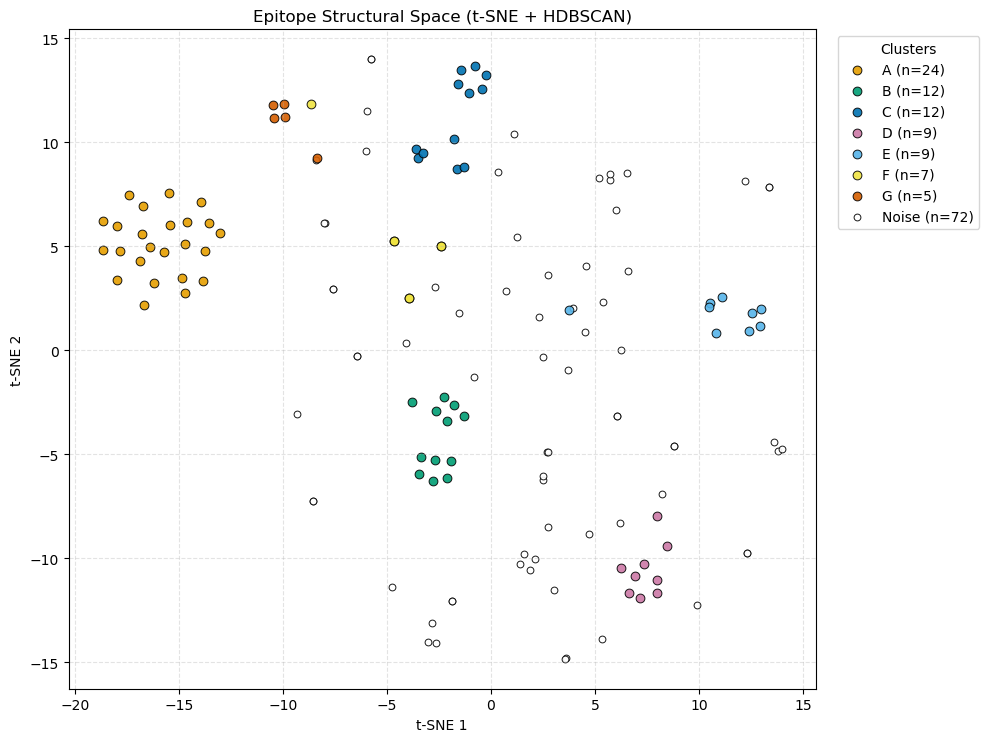

In [157]:
# 11. 2D Plot (t-SNE + HDBSCAN)

fig, ax = plt.subplots(figsize=FIGSIZE)

# Noise
noise_df = df_viz[df_viz["hdbscan_id"] == -1]
ax.scatter(
    noise_df["x"], noise_df["y"],
    c=NOISE_COLOR, s=24, alpha=0.9,
    edgecolors="black", linewidths=0.7,
    label=f"Noise (n={len(noise_df)})"
)

# Clusters
for cid in cluster_ids_sorted:
    cdf = df_viz[df_viz["hdbscan_id"] == cid]
    ax.scatter(
        cdf["x"], cdf["y"],
        c=cid2color[cid],
        s=40, alpha=0.9,
        edgecolors="black", linewidths=0.7,
        label=f"{cid2name[cid].split()[-1]} (n={len(cdf)})"
    )

ax.set_aspect("equal")

ax.xaxis.set_major_locator(MultipleLocator(GRID_STEP))
ax.yaxis.set_major_locator(MultipleLocator(GRID_STEP))
ax.grid(True, linestyle="--", alpha=0.35)

ax.set_title("Epitope Structural Space (t-SNE + HDBSCAN)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")

# Legend reorder: Cluster A, ..., G, and Noise 
handles, labels = ax.get_legend_handles_labels()

cluster_items = []
noise_item = None

for h, l in zip(handles, labels):
    if l.startswith("Noise"):
        noise_item = (h, l)
    else:
        cluster_items.append((h, l))

new_handles = [h for h, _ in cluster_items]
new_labels  = [l for _, l in cluster_items]

if noise_item is not None:
    new_handles.append(noise_item[0])
    new_labels.append(noise_item[1])

ax.legend(
    new_handles,
    new_labels,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Clusters",
)

plt.tight_layout()
plt.show()


In [148]:
# 12. Cluster-wise Distance Statistics
stats = []

for cid in cluster_ids_sorted:
    cname = cid2name[cid]
    members = df_viz.loc[df_viz["hdbscan_id"] == cid, "id"].tolist()
    idx = [ids.index(m) for m in members]

    sub = dist[np.ix_(idx, idx)]
    dvals = sub[np.triu_indices(len(members), k=1)] if len(members) > 1 else np.array([])

    stats.append({
        "cluster": cname,
        "n": len(members),
        "max_dist": float(dvals.max()) if dvals.size else np.nan,
        "med_dist": float(np.median(dvals)) if dvals.size else np.nan,
        "min_dist": float(dvals.min()) if dvals.size else np.nan,
        "members": ", ".join(members),
    })

df_stats = pd.DataFrame(stats)
df_stats


,cluster,n,max_dist,med_dist,min_dist,members
0,A,24,0.394655,0.298320,0.079575,"A0A0F6N3V8, A0A0U1Y1N5, AAA32702, AAD25926, AA..."
1,B,12,0.684285,0.425745,0.009610,"O43099, O93969, P14292, P56577, P56578, Q00002..."
2,C,12,0.657925,0.562852,0.000750,"AHY02994, G8Z407, G8Z408, P0C1B3, P42040, Q0CJ..."
3,D,9,0.672900,0.252995,0.000000,"A0A3G3LP85, AAB40400, AAM77471, AAT66566, AAT6..."
4,E,9,0.648230,0.530502,0.206895,"H2E5X2, P42037, P42039, P49148, P50344, P83340..."
5,F,7,0.644430,0.518735,0.005590,"ABA42918, P0C0Y4, P0C0Y5, P42058, P42059, Q9Y7..."
6,G,5,0.557550,0.020745,0.006570,"BAH09387, CAD23374, CAD23611, Q01940, Q9UW98"


In [149]:
# 13. Save Outputs

df_viz[["id", "cluster", "hdbscan_id"]].to_csv(
    OUT_DIR / "cluster_assignments.tsv",
    sep="\t",
    index=False,
)

with open(OUT_DIR / "cluster_stats.txt", "w") as f:
    for _, r in df_stats.iterrows():
        f.write(f"{r['cluster']}\n")
        f.write(f"n={r['n']}\n")
        f.write(f"max_dist={r['max_dist']}\n")
        f.write(f"med_dist={r['med_dist']}\n")
        f.write(f"min_dist={r['min_dist']}\n")
        f.write(f"{r['members']}\n\n")

print("Saved outputs to:", OUT_DIR)


Saved outputs to: /home/ktkim/AllerScope_raw/analysis
